O seguinte notebook tem como objetivo aplicar uma análise descritiva, teste de hipóteses e também análise de sobrevivência aplicada a um conjunto de dados relacionado à evasão escolar no curso de Bacharel em Estatística da UFRGS. Os dados foram digitalizados do TCC de referência utilizado: https://lume.ufrgs.br/bitstream/handle/10183/198131/000188649.pdf?sequence=1

"A evasão é um problema que merece ser estudado com profundidade, tanto pelo aspecto pedagógico envolvido, como econômico e social. Alguns cursos superiores da UFRGS são caracterizados como cursos onde a evasão é grande e preocupante. Diversas causas, identificadas através de pesquisas realizadas pela Universidade, são apontadas: necessidade de trabalhar, incompatibilidade de horário de trabalho e estudo, curso não correspondeu às expectativas, etc."

"Dentre os cursos em que a evasão é preocupante, encontra-se o Curso de Bacharelado em Estatística. Assim, este trabalho visa analisar o tempo de permanência dos alunos no curso, até a sua evasão, permitindo, desta maneira, que seja estudado um exemplo prático na área educacional com aplicação da técnica estatística Análise de Sobrevivência, utilizando os alunos do Curso de Estatística como população de estudo."

- $H_o$: As médias das idades dos dois grupos de alunos são iguais.
- $H_a$: As médias das idades dos dois grupos de alunos são diferentes.

In [12]:
import numpy as np
import pandas as pd

from scipy import stats
from matplotlib import pyplot as plt
from IPython.display import Image

from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lifelines import KaplanMeierFitter, NelsonAalenFitter

pd.options.display.float_format = "{:,.2f}".format

Primeiramente vou fazer a análise descritiva dos dados completos e além disso a análise exploratória, após isso a separação das amostras para responder às hipóteses juntamente com a análise de sobrevivência.
A hipótese é, dos alunos censurados, isto é, dos evasivos, existe alguma diferença nas médias das idades dos gêneros. 

In [2]:
df = pd.read_csv("../dataset/data.csv")

df.columns = ['ingresso', 'genero', 'idade', 'n_aprovacoes', 'n_reprovacoes', 'tempo', 'censura', 'ano_ingresso']

dfs = df[df["censura"] == 1]
gen1 = dfs.loc[dfs["genero"] == 1, "idade"]
gen2 = dfs.loc[dfs["genero"] == 2, "idade"]

### 1.0. Análise Descritiva

In [3]:
aux = df.describe().T
aux["skew"] = df.apply(lambda x: x.skew())
aux["kurtosis"] = df.apply(lambda x: x.kurtosis())
aux

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
ingresso,150.00,1.41,1.02,1.00,1.00,1.00,1.00,7.00,3.46,13.92
genero,150.00,1.31,0.47,1.00,1.00,1.00,2.00,2.00,0.81,-1.36
idade,150.00,22.85,5.58,17.00,19.00,21.00,26.00,43.00,1.46,1.97
n_aprovacoes,150.00,2.04,1.85,0.00,0.00,2.00,3.00,7.00,0.55,-0.70
n_reprovacoes,150.00,1.90,1.51,0.00,1.00,2.00,3.00,6.00,0.77,0.03
tempo,150.00,6.09,4.44,1.00,3.00,4.50,8.00,22.00,1.42,1.71
censura,150.00,0.69,0.46,0.00,0.00,1.00,1.00,1.00,-0.85,-1.30
ano_ingresso,150.00,89.85,3.26,85.00,87.00,90.00,93.00,95.00,0.01,-1.31


In [4]:
df["ingresso"].value_counts()

ingresso
1    118
2     16
3     11
7      2
6      1
4      1
5      1
Name: count, dtype: int64

In [5]:
dfs[["genero", "idade"]].groupby("genero").agg(
    mean=("idade", "mean"),
    std=("idade", "std"),
    n=("idade", "count")
)

,mean,std,n
genero,,,
1,24.08,5.91,73
2,20.29,3.67,31


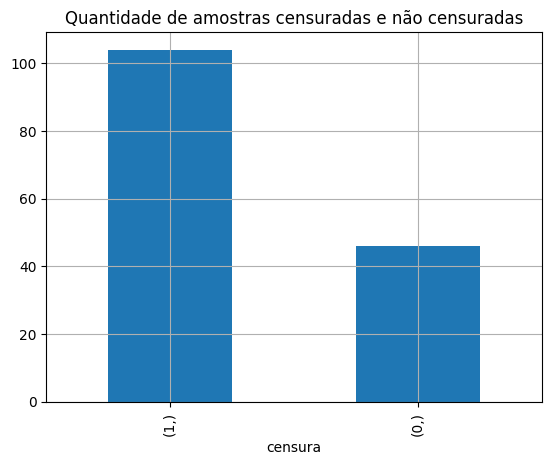

In [4]:
ax = df[["censura"]].value_counts().plot(kind="bar");
ax.grid(2);
ax.set_title("Quantidade de amostras censuradas e não censuradas");

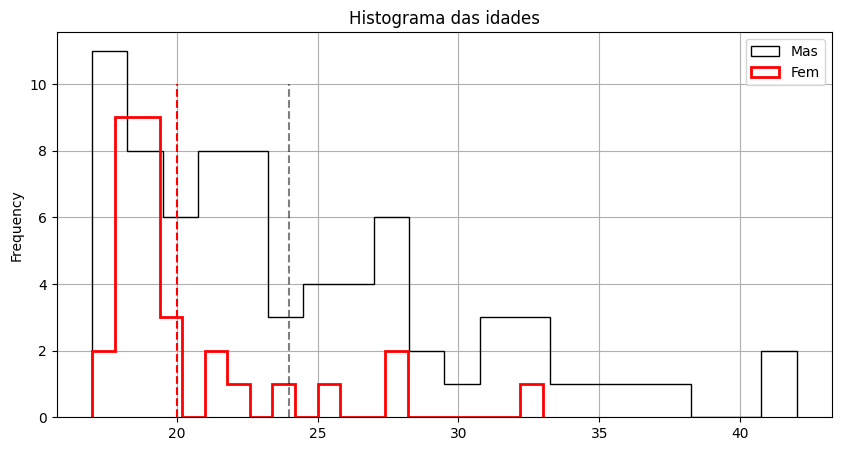

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
gen1.plot(kind="hist", histtype="step", label="Mas", color="k", legend=True, grid=2, bins=20)
ax = gen2.plot(kind="hist", histtype="step", label="Fem", color="r", legend=True, grid=2, linewidth=2, bins=20);
ax.vlines(int(gen1.mean()), ymin=0, ymax=10, color="k", linestyles="--", alpha=0.5)
ax.vlines(int(gen2.mean()), ymin=0, ymax=10, color="r", linestyles="--")

ax.set_title("Histograma das idades");

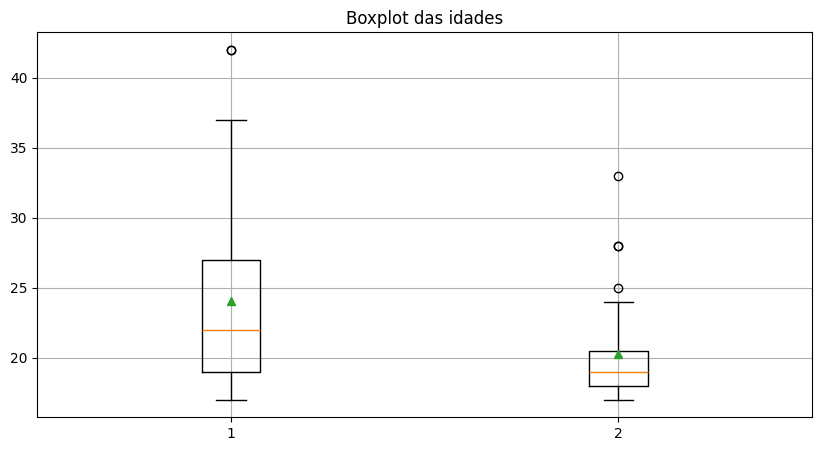

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.boxplot([gen1, gen2], label=["1", "2"], showmeans=True);
ax.grid(True);
ax.set_title("Boxplot das idades");

Pontos Interessantes:

- A média da censura é aproximadamente 70%, isso caracteriza um desbalanceamento de classes.
- Existem ingressantes no curso de estatística menores de 18 anos.
- Mais de 50% dos alunos intrevistados entraram por meio do vestibular tradicional (ingresso = 1).
- Intervalo de estudantes em 10 anos de ingresso no curso.


### 2.0. Análise Exploratória

In [8]:
hist_params = {
    "bins": 10,
    "legend": True,
    "histtype": "step"
}

#### 2.1. Análise Univariada

É notavel que, amostras nos anos finais de estudo a censura não vai ser identificada devido que o evento de interesse ainda não aconteceu, isso é notável pelo histograma, pessoas que entraram no curso mais recentemente ainda não teve o tempo de maturação para evadir. 

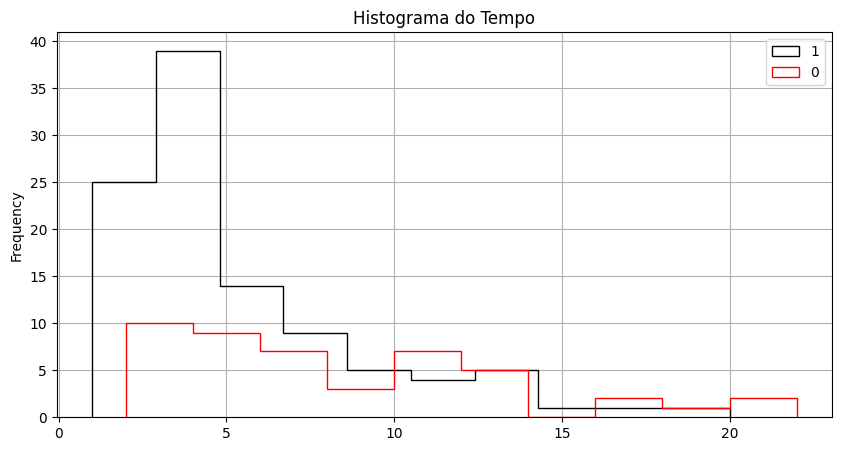

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
df.loc[df["censura"] == 1, "tempo"].plot(kind="hist", label="1", color="k", **hist_params)
ax = df.loc[df["censura"] == 0, "tempo"].plot(kind="hist", label="0", color="r", **hist_params);
ax.set_title("Histograma do Tempo");
ax.grid(2);

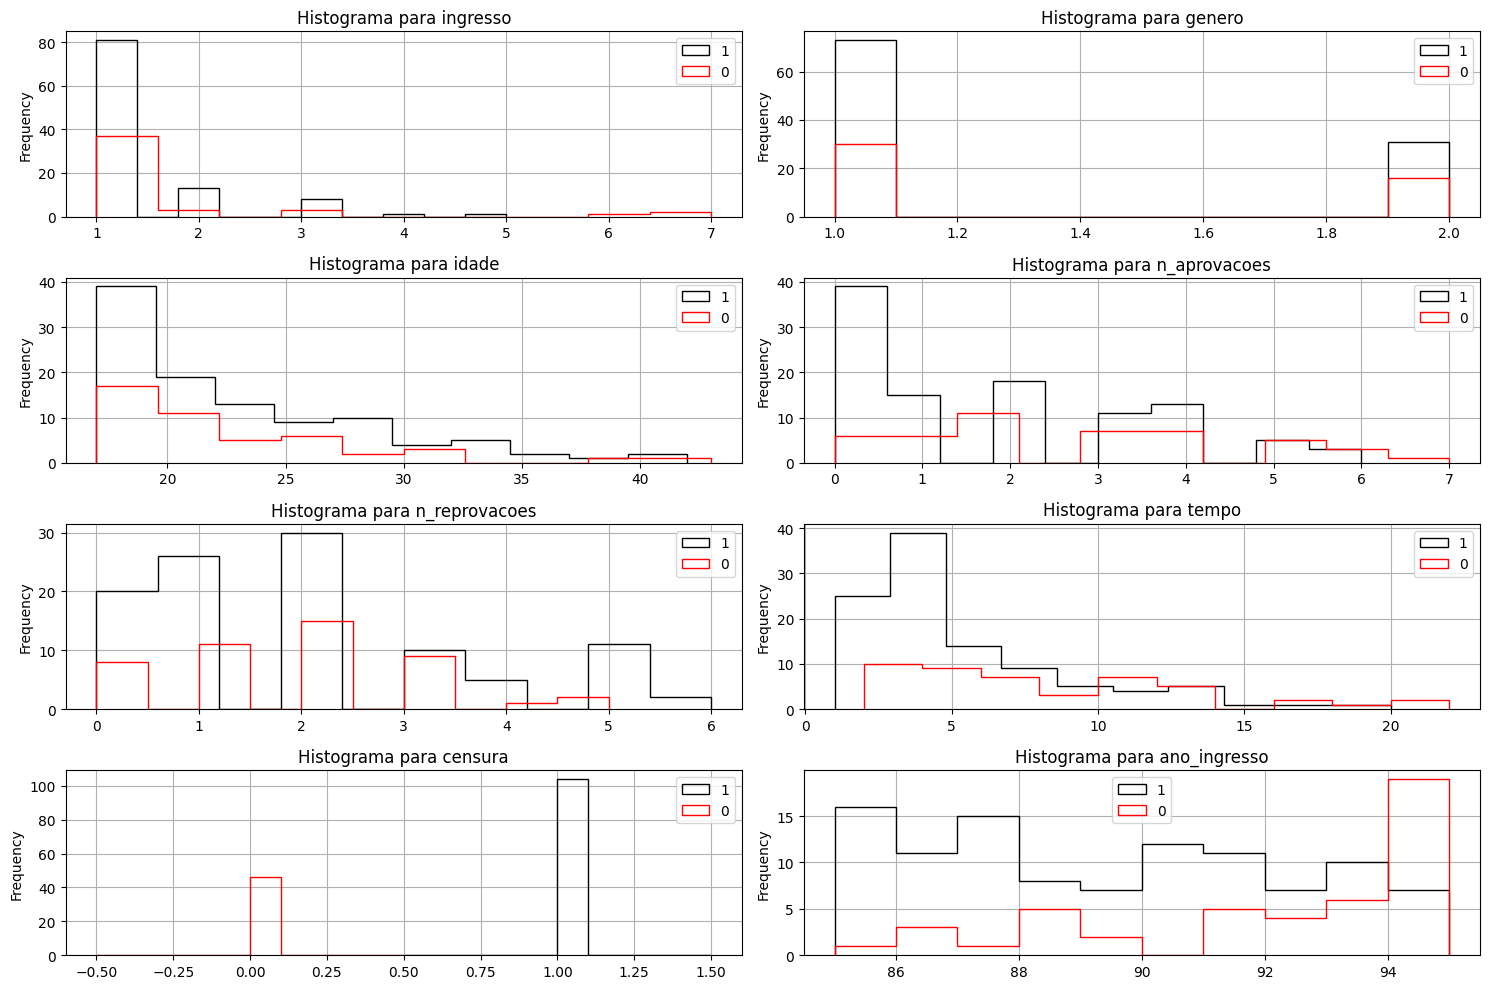

In [10]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10))
ax = ax.flatten()

for axi, coli in zip(
    ax, df.columns
):
    df.loc[df["censura"] == 1, coli].plot(kind="hist", label="1", color="k", ax=axi, **hist_params)
    df.loc[df["censura"] == 0, coli].plot(kind="hist", label="0", color="r", ax=axi, **hist_params)

    axi.set_title(f"Histograma para {coli}")
    axi.grid(2)

plt.tight_layout()

#### 2.2. Análise Bivariada

##### 2.2.1. Mind Map

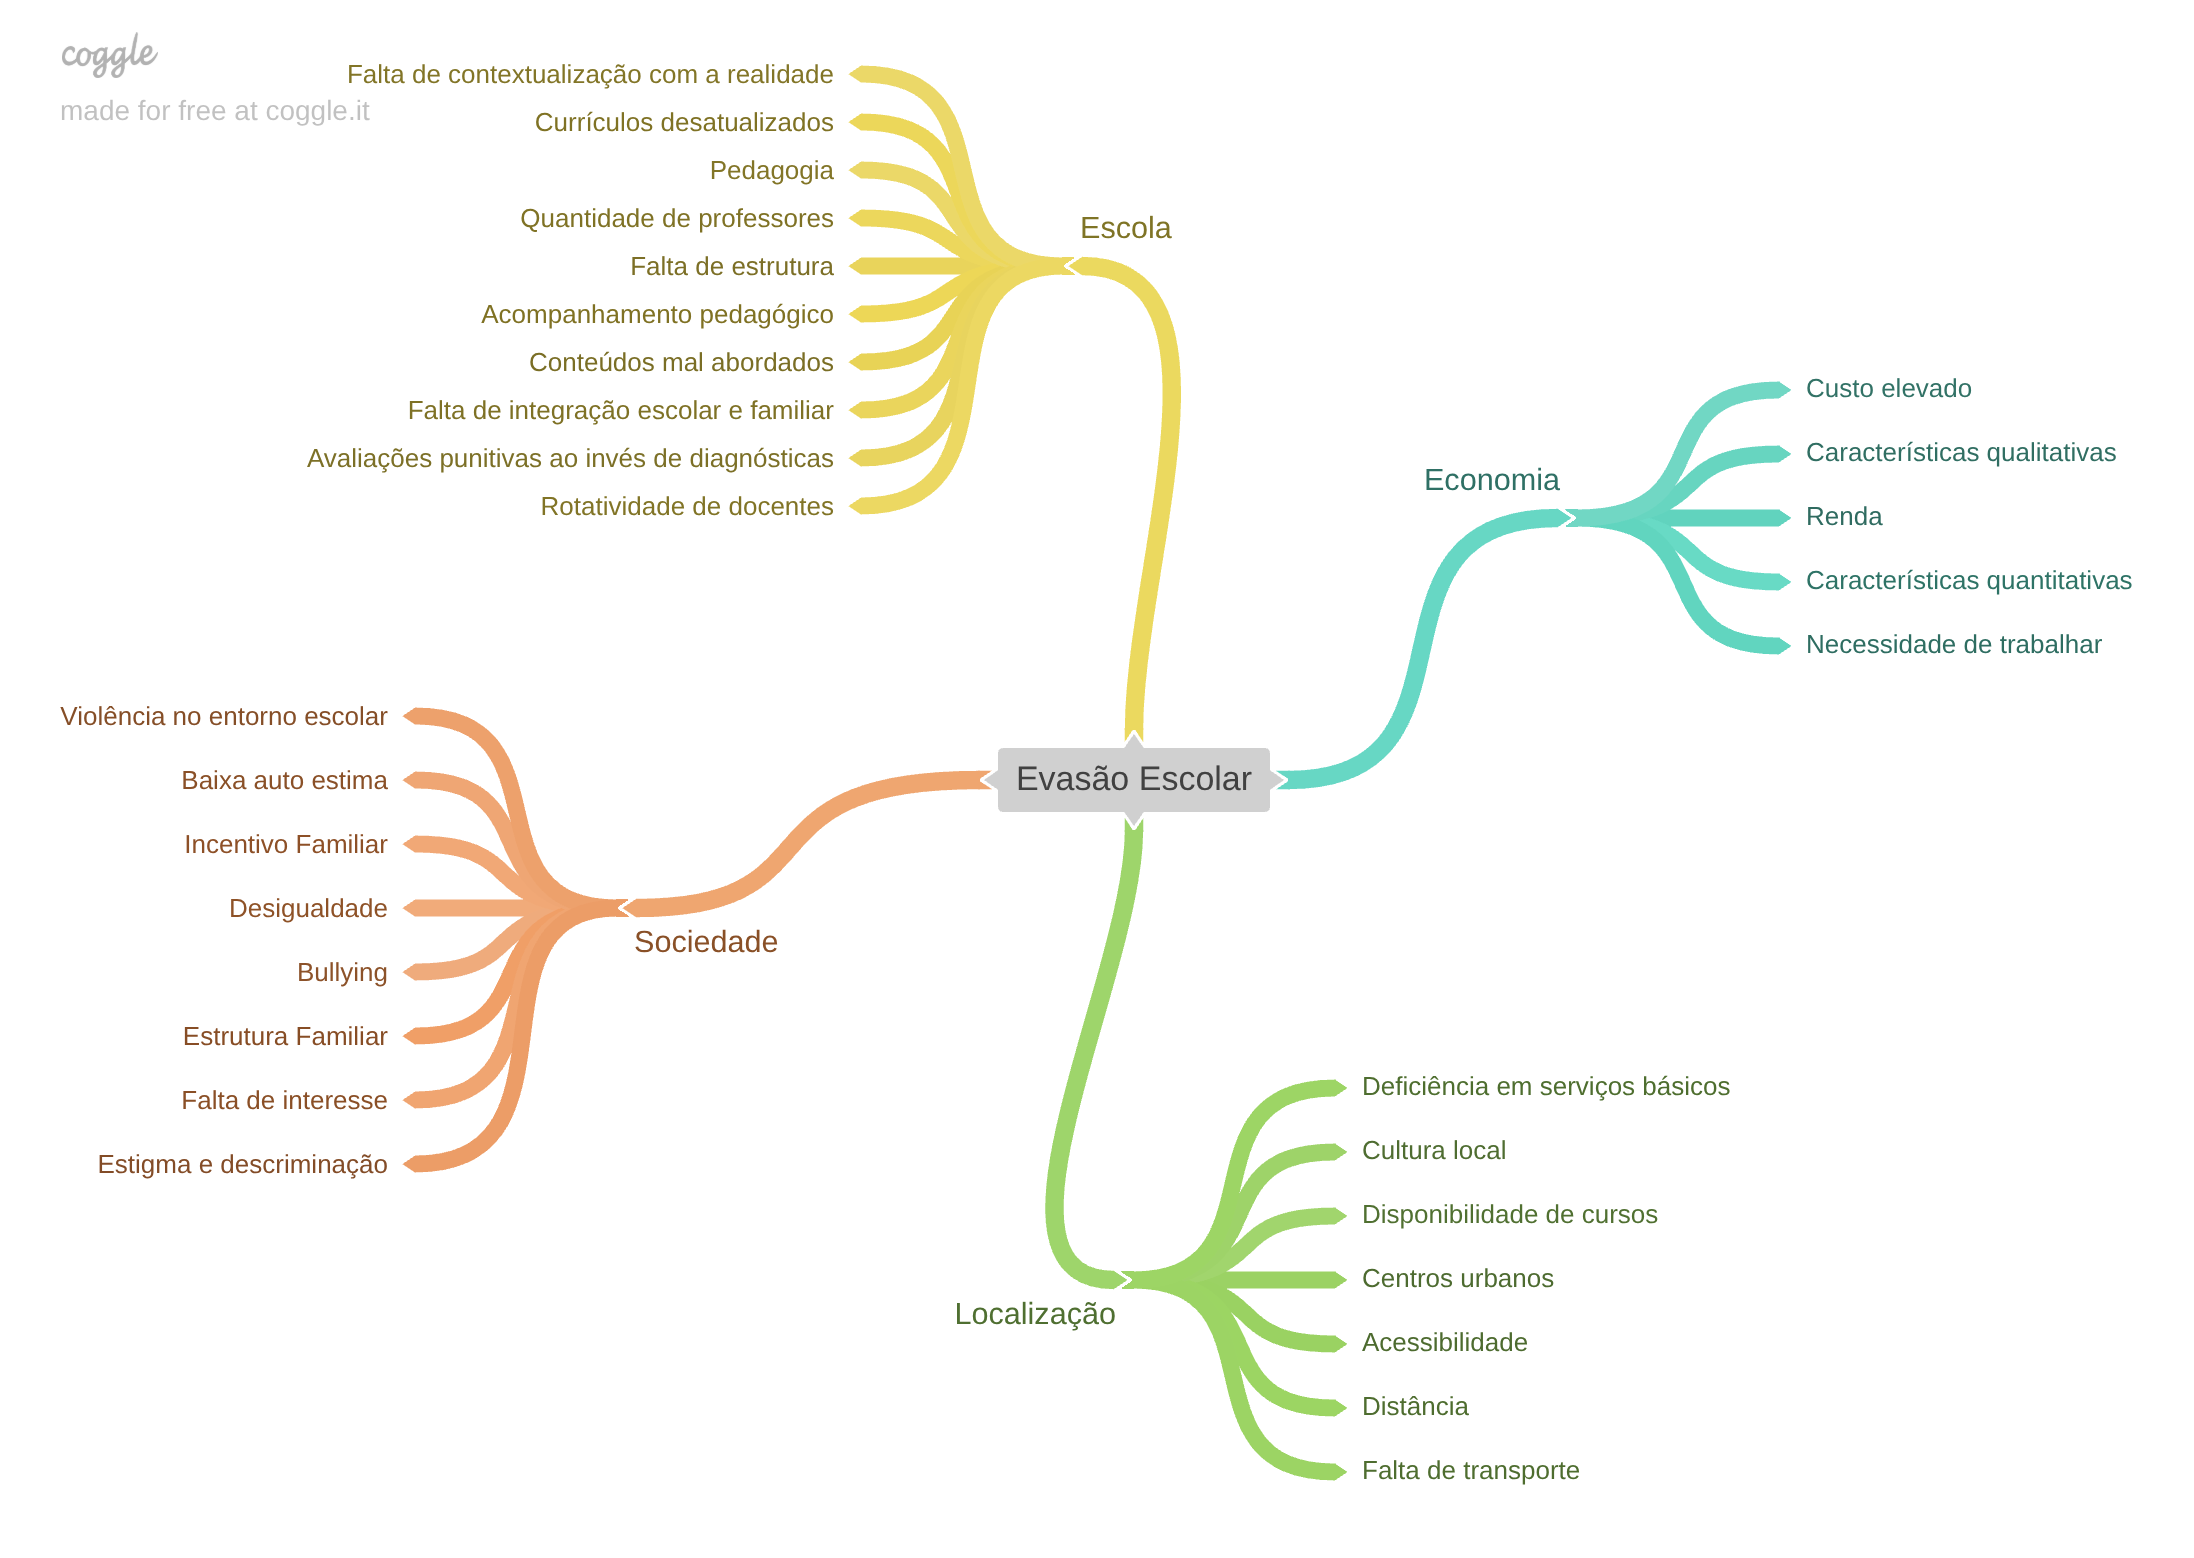

In [13]:
Image("../assets/mindmap.png")

##### 2.2.2. Análise Bivariada

In [33]:
censurado = df["censura"] == 1

In [54]:
df.head()

,ingresso,genero,idade,n_aprovacoes,n_reprovacoes,tempo,censura,ano_ingresso
0,1,1,26,0,1,5,1,85
1,6,2,21,7,0,6,0,92
2,1,1,32,4,0,12,1,87
3,1,1,18,4,0,3,1,92
4,1,1,24,2,0,17,1,86


Censuras por formas de ingresso.

É possível notar, que as duas amostras providas da forma de ingresso igual a 7 não foram sensuradas. Além disso, ambas as amostras possuem características totalmente diferentes.

Analisando também o ingresso em relação ao tempo do curso juntamente se o aluno abandonou ou não é notável que as três amostras dos tipos de ingresso 6 e 7 não abandonaram o curso, provavelmente isso seria detectado como ruido e em uma eventual modelagem de dados o modelo iria se agarrar nesses pequenos detalhes.

,censura,ingresso,contagem
0,0,1,37
1,0,2,3
2,0,3,3
3,0,6,1
4,0,7,2
5,1,1,81
6,1,2,13
7,1,3,8
8,1,4,1
9,1,5,1


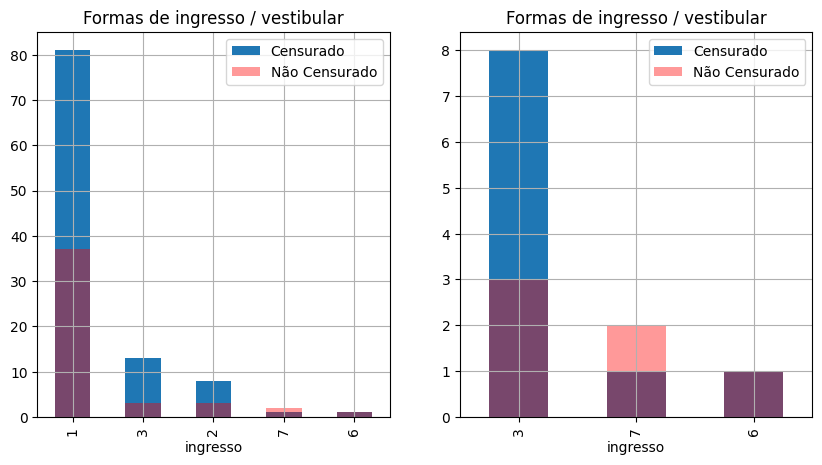

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()
df[censurado]["ingresso"].value_counts().plot(kind="bar", ax=ax[0], label="Censurado")
df[~censurado]["ingresso"].value_counts().plot(kind="bar", ax=ax[0], alpha=0.4, color="red", label="Não Censurado")

df[(censurado) & (df["ingresso"] > 2)]["ingresso"].value_counts().plot(kind="bar", ax=ax[1], label="Censurado")
df[(~censurado) & (df["ingresso"] > 2)]["ingresso"].value_counts().plot(kind="bar", ax=ax[1], alpha=0.4, color="red", label="Não Censurado")

for axi in ax:
    axi.grid(2)
    axi.legend()
    axi.set_title("Formas de ingresso / vestibular")

df[["genero", "censura", "ingresso"]].groupby(["censura", "ingresso"]).count().reset_index().rename(columns={"genero": "contagem"})

In [77]:
df[df["ingresso"] == 7]

,ingresso,genero,idade,n_aprovacoes,n_reprovacoes,tempo,censura,ano_ingresso
39,7,1,23,2,2,12,0,88
145,7,2,19,1,0,2,0,95


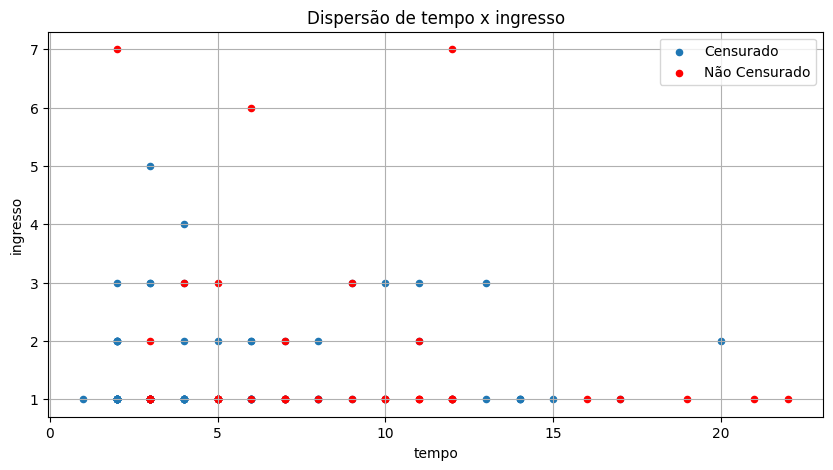

In [108]:
fig, ax = plt.subplots(figsize=(10, 5))
df.loc[(censurado), ["tempo", "ingresso"]].plot(x="tempo", y="ingresso", kind="scatter", ax=ax, label="Censurado")
df.loc[(~censurado), ["tempo", "ingresso"]].plot(x="tempo", y="ingresso", kind="scatter", ax=ax, color="red", label="Não Censurado")
ax.set_title("Dispersão de tempo x ingresso")
ax.grid(2)
ax.legend();

Censuras por gênero.

Não existe nenhuma diferença relativamente grande entre gênero e a evasão do curso, é possível ver esse detalhe tanto nos histogramas quanto nos alunos que abandonaram e não abandonaram o curso. A proporção se mantem a masma para ambos os generos.

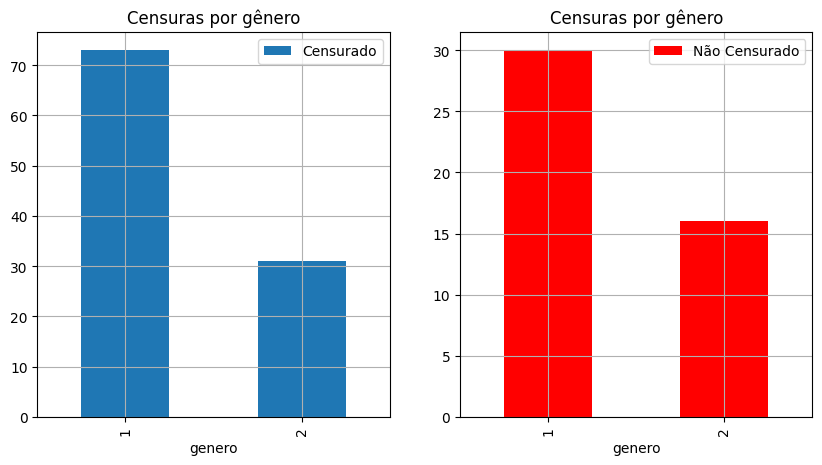

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()
df[censurado]["genero"].value_counts().plot(kind="bar", ax=ax[0], label="Censurado")
df[~censurado]["genero"].value_counts().plot(kind="bar", ax=ax[1], color="red", label="Não Censurado")

for axi in ax:
    axi.grid(2)
    axi.set_title("Censuras por gênero")
    axi.legend()

In [81]:
display(df[censurado]["genero"].value_counts() / df[censurado].shape[0])
display(df[~censurado]["genero"].value_counts() / df[~censurado].shape[0])

genero
1   0.70
2   0.30
Name: count, dtype: float64

genero
1   0.65
2   0.35
Name: count, dtype: float64

Distribuição das idades dos alunos.

Visualmente não existe nenhuma diferença significativa desses alunos por meio de suas idades.

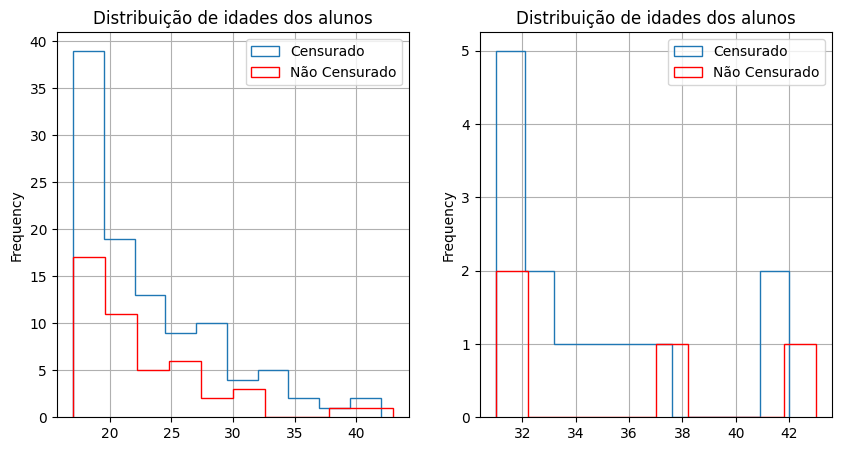

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()
df[censurado]["idade"].plot(kind="hist", ax=ax[0], **hist_params, label="Censurado")
df[~censurado]["idade"].plot(kind="hist", ax=ax[0], **hist_params,  color="red", label="Não Censurado");
df[(censurado) & (df["idade"] > 30)]["idade"].plot(kind="hist", ax=ax[1], **hist_params, label="Censurado")
df[(~censurado) & (df["idade"] > 30)]["idade"].plot(kind="hist", ax=ax[1], **hist_params,  color="red", label="Não Censurado");

for axi in ax:
    axi.set_title("Distribuição de idades dos alunos")
    axi.grid(2);

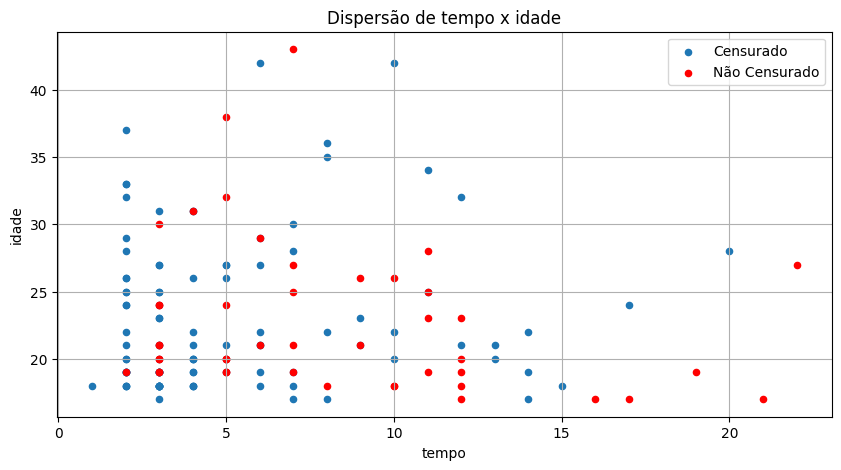

In [107]:
fig, ax = plt.subplots(figsize=(10, 5))
df.loc[(censurado), ["tempo", "idade"]].plot(x="tempo", y="idade", kind="scatter", ax=ax, label="Censurado")
df.loc[(~censurado), ["tempo", "idade"]].plot(x="tempo", y="idade", kind="scatter", ax=ax, color="red", label="Não Censurado")
ax.set_title("Dispersão de tempo x idade")
ax.grid(2)
ax.legend();

Censura em relação ao ano de ingresso.

É possível notar que, no ano de 1995 dado ao fato que os alunos estão iniciando o curso, não existe uma grande quantidade de evasão, mas, acredito que ao longo de mais dois anos de curso, mais de 50% dos alunos abandonam o curso. É possível notar que no ano de ingresso de 1990, todos os alunos, ingressados neste ano, abandonaram no curso.

Já dos ingressantes em 1985, apenas um continuou vivo no curso até o momento da coleta dos dados. Quanto mais o tempo passa, é possível notar isso no gráfico de dispersão, mais os alunos abandonam o curso.

,censura,ano_ingresso,contagem
0,0,85,1
1,0,86,3
2,0,87,1
3,0,88,5
4,0,89,2
5,0,91,5
6,0,92,4
7,0,93,6
8,0,94,9
9,0,95,10


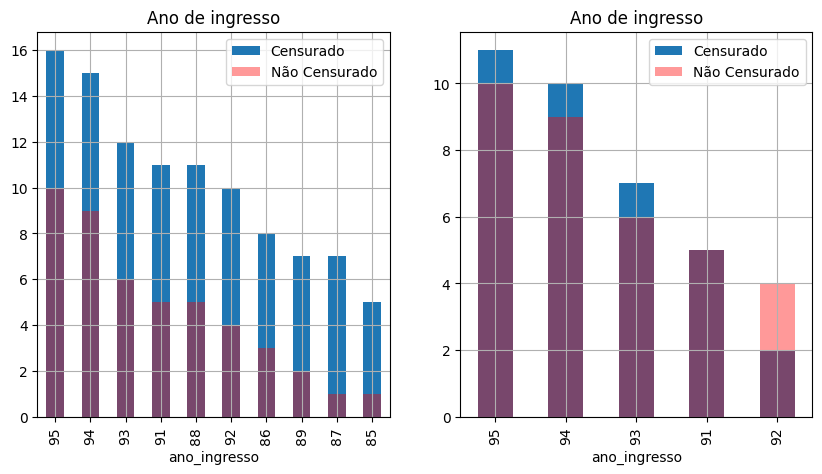

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()
df[censurado]["ano_ingresso"].value_counts().plot(kind="bar", ax=ax[0], label="Censurado")
df[~censurado]["ano_ingresso"].value_counts().plot(kind="bar", ax=ax[0], alpha=0.4, color="red", label="Não Censurado")

df[(censurado) & (df["ano_ingresso"] > 90)]["ano_ingresso"].value_counts().plot(kind="bar", ax=ax[1], label="Censurado")
df[(~censurado) & (df["ano_ingresso"] > 90)]["ano_ingresso"].value_counts().plot(kind="bar", ax=ax[1], alpha=0.4, color="red", label="Não Censurado")

for axi in ax:
    axi.grid(2)
    axi.legend()
    axi.set_title("Ano de ingresso")

df[["genero", "censura", "ano_ingresso"]].groupby(["censura", "ano_ingresso"]).count().reset_index().rename(columns={"genero": "contagem"})

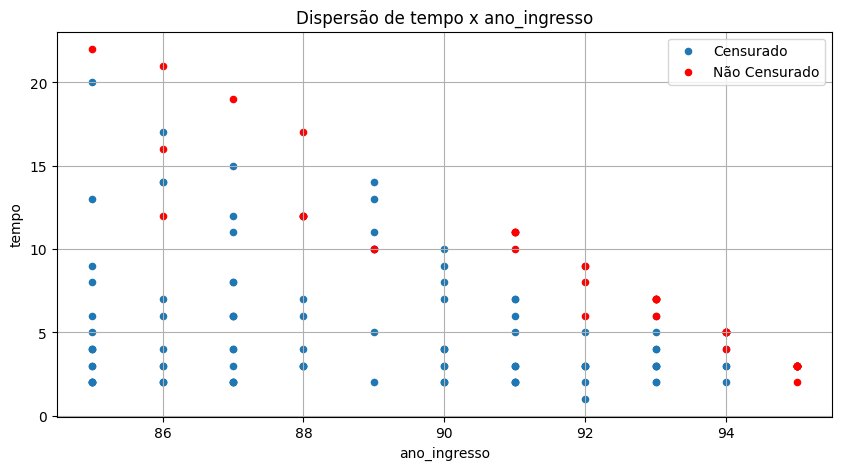

In [116]:
fig, ax = plt.subplots(figsize=(10, 5))
df.loc[(censurado), ["tempo", "ano_ingresso"]].plot(x="ano_ingresso", y="tempo", kind="scatter", ax=ax, label="Censurado")
df.loc[(~censurado), ["tempo", "ano_ingresso"]].plot(x="ano_ingresso", y="tempo", kind="scatter", ax=ax, color="red", label="Não Censurado")
ax.set_title("Dispersão de tempo x ano_ingresso")
ax.grid(2)
ax.legend();

##### 2.2.3. Redução da Dimensionalidade

In [17]:
X = df.drop(columns=["censura"], axis=1)

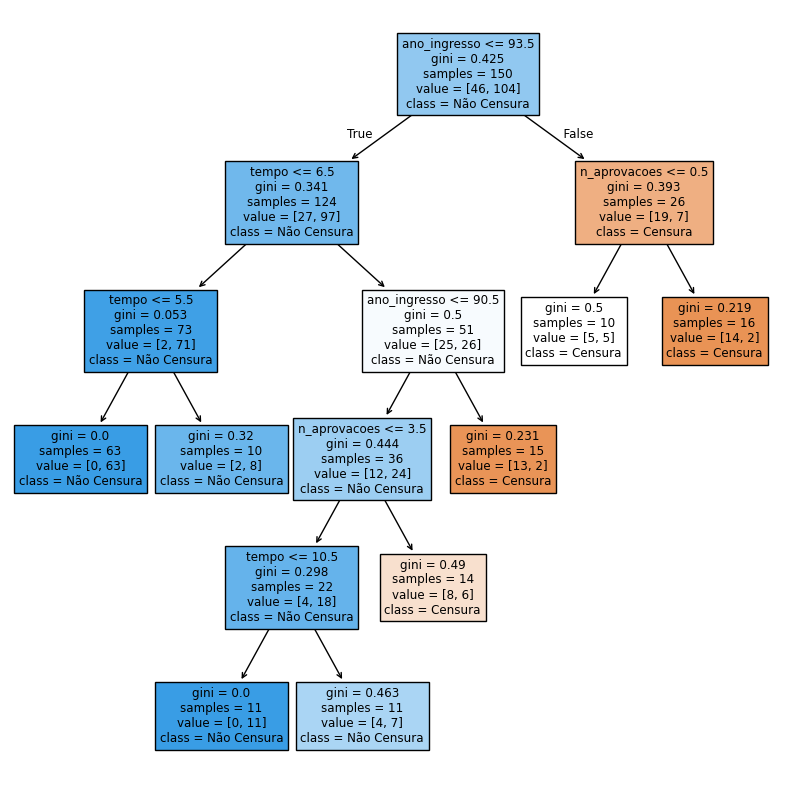

In [83]:
dtc = DecisionTreeClassifier(
    min_samples_leaf=10
)

dtc.fit(
    X=X,
    y=df["censura"]
)

fig, ax = plt.subplots(figsize=(10,10))
plot_tree(
    dtc,
    class_names=df["censura"].apply(lambda x: "Censura" if x else "Não Censura"),
    feature_names=X.columns,
    filled=True
);

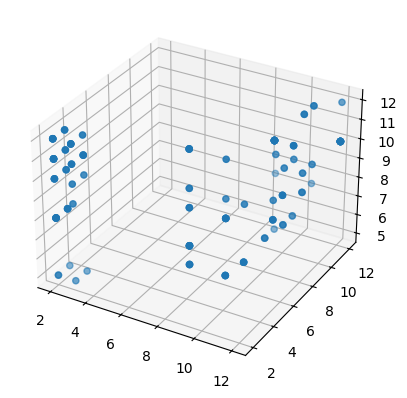

In [96]:
dtc = RandomForestClassifier(
    n_jobs=-1,
    n_estimators=3,
    min_samples_leaf=10
)

dtc.fit(
    X=X,
    y=df["censura"]
)

lf = pd.DataFrame(dtc.apply(X))

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(lf[0], lf[1], lf[2]);

#### 2.3. Análise Multivariada

Uma pequena análise das correlações lineares entre pares de variáveis é possível notar que a censura tem correlação negativa com quase todas as variáveis. 

In [91]:
df.corr()

,ingresso,genero,idade,n_aprovacoes,n_reprovacoes,tempo,censura,ano_ingresso
ingresso,1.00,0.05,0.09,-0.03,-0.14,0.01,-0.10,-0.04
genero,0.05,1.00,-0.30,0.06,0.04,-0.00,-0.05,0.01
idade,0.09,-0.30,1.00,-0.30,-0.04,-0.01,0.03,-0.01
n_aprovacoes,-0.03,0.06,-0.30,1.00,-0.34,0.36,-0.26,-0.05
n_reprovacoes,-0.14,0.04,-0.04,-0.34,1.00,-0.15,0.05,0.05
tempo,0.01,-0.00,-0.01,0.36,-0.15,1.00,-0.31,-0.32
censura,-0.10,-0.05,0.03,-0.26,0.05,-0.31,1.00,-0.41
ano_ingresso,-0.04,0.01,-0.01,-0.05,0.05,-0.32,-0.41,1.00
